In [1]:
seq = '../data/rev_sequencing.tsv'
qc = '../out/rev_seq_qc.tsv'
sgd = '../out/SGD_features.tab'
known = 'known_suppressors.tsv'

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
import numpy as np
import pandas as pd

In [4]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
rgn = g[g[1] == 'ORF'].set_index(4)[3].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [5]:
d = {'S288C': 'S288C',
     'Y55': 'Y55',
     'UWOPS87': 'UWOP',
     'YPS606': 'YPS'}

In [6]:
strains = ['S288C', 'Y55',
           'UWOP', 'YPS']
cstrains = {x: c
            for x, c in zip(strains, sns.color_palette('Set1', len(strains)))}

In [7]:
s = pd.read_csv(seq, sep='\t')

In [8]:
q = pd.read_csv(qc, sep='\t')

In [9]:
k = pd.read_csv(known, sep='\t')
k = k.set_index(['Query gene',
                 'Suppressor gene'])

In [10]:
samples = set(q[(q['depth'] >= 0.7) &
                (q['sample'].str.startswith('Gback'))]['sample'].unique())

In [11]:
sd = s.set_index('sample')['strain'].to_dict()
sg = s.set_index('sample')['gene'].to_dict()

In [12]:
res = []
res1 = []
w = None
for gene, strain, kind, sample in s[(s['sample'].isin(samples))].values:
    try:
        v = pd.read_csv('../data/snippy/%s/snps.tab' % sample,
                        sep='\t')
        c = v[v['FTYPE'] == 'CDS'].copy()
        c = c[(~c['EFFECT'].str.contains('synonymous_variant'))
             ].groupby('GENE')['CHROM'].count()
        c.name = '%s_%s' % (sample, kind)
    except:
        continue
    if w is None:
        w = c.to_frame()
    else:
        w = w.join(c.to_frame(), how='outer')
        w[np.isnan(w)] = 0.0

o = w[[x for x in w.columns if 'original' in x]]
n = w[[x for x in w.columns if 'new' in x]]

o.columns = [x.split('_')[0] for x in o.columns]
# o = (o.T - o['BY4741']).T
tt = o.copy()
tt[tt > 0] = 1
cc = tt.T.sum()
for (gene, sample), value in zip(o.stack().index, o.stack().values):
    if value == 0:
        continue
    res1.append([d[sd[sample]], sg[sample], gene, value])
o = o.loc[cc[cc < 2].index]
for sample, value in zip(o.sum().index, o.sum().values):
    res.append([d[sd[sample]], sg[sample], value])

In [13]:
r = pd.DataFrame(res,
                 columns=['strain', 'gene', 'muts'])

In [14]:
r1 = pd.DataFrame(res1,
                  columns=['strain', 'gene', 'mutated', 'muts'])

In [15]:
r1 = r1.set_index(['gene', 'mutated'])

In [16]:
len(r1.index.intersection(k.index))

0

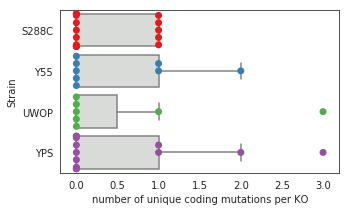

In [17]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=r,
            x='muts',
            y='strain',
            order=strains,
            showfliers=False,
            color=sns.xkcd_rgb['light grey'])
sns.swarmplot(data=r,
            x='muts',
            y='strain',
            order=strains,
            palette=cstrains,
            size=7)
plt.ylabel('Strain')
plt.xlabel('number of unique coding mutations per KO')

plt.savefig('ko_sequencing_boxplot_all.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('ko_sequencing_boxplot_all.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [18]:
a = None

for gene in s['gene'].unique():
    for strain in d:
        try:
            os = s[(s['gene'] == gene) &
                   (s['strain'] == strain) &
                   (s['set'] == 'original')]['sample'].values[0]
            ns = s[(s['gene'] == gene) &
                   (s['strain'] == strain) &
                   (s['set'] == 'new')]['sample'].values[0]
            if os not in samples or ns not in samples:
                continue
            v1 = pd.read_csv('../data/snippy/%s/snps.tab' % os,
                             sep='\t')
            c1 = v1[v1['FTYPE'] == 'CDS'].copy()
            c1 = c1[(~c1['EFFECT'].str.contains('synonymous_variant'))
                   ].groupby('GENE')['CHROM'].count()
            v2 = pd.read_csv('../data/snippy/%s/snps.tab' % ns,
                             sep='\t')
            c2 = v2[v2['FTYPE'] == 'CDS'].copy()
            c2 = c2[(~c2['EFFECT'].str.contains('synonymous_variant'))
                   ].groupby('GENE')['CHROM'].count()
            c1.name = 'original'
            c2.name = 'new'
            c = c1.to_frame().join(c2.to_frame(), how='outer')
            c[np.isnan(c)] = 0
        except:
            continue
        
        if '(WT)' in gene:
            gene = 'WT'
            print(gene)
        
        c = c.T
        c.index = ['%s_%s_%s' % (d[strain],
                                 gene, x)
                   for x in c.index]
        c = c.T
        if a is None:
            a = c
        else:
            a = a.join(c, how='outer')

In [19]:
t = a.sum()

In [20]:
for x in sorted({' '.join(x.split('_')[:2]) for x in t.index}):
    print(x)

S288C AVL9
S288C BCS1
S288C BY4741
S288C CHL1
S288C HOC1
S288C HOG1
S288C MAL11
S288C MAL32
S288C MET5
S288C PBS2
S288C SLM1
UWOP ERG2
UWOP PET130
UWOP SLM1
Y55 AVL9
YPS AVL9
YPS ERG2
YPS SLM1


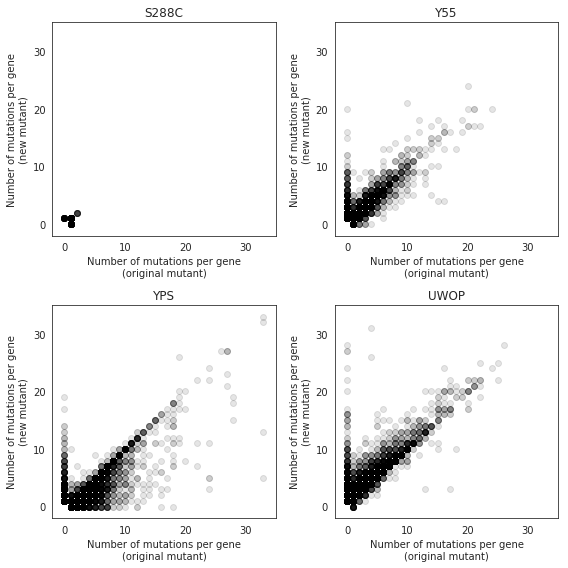

In [21]:
plt.figure(figsize=(8, 8))

for i, strain in enumerate(['S288C', 'Y55',
                            'YPS', 'UWOP']):
    plt.subplot(2, 2, i + 1)
    
    for gene in {x.split('_')[1] for x in a.columns
                 if x.split('_')[0] == strain}:
        v = a[['%s_%s_original' % (strain, gene),
               '%s_%s_new' % (strain, gene),]].dropna()
        v['delta'] = abs(v[v.columns[0]] - v[v.columns[1]])
        plt.plot(v[v.columns[0]],
                 v[v.columns[1]],
                 'ko',
                 alpha=0.1,
                 rasterized=True)

    plt.xlim(-2, 35)
    plt.ylim(-2, 35)
    
    plt.title(strain)
    
    plt.xlabel('Number of mutations per gene\n(original mutant)')
    plt.ylabel('Number of mutations per gene\n(new mutant)')
    
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(4))
    
plt.tight_layout()

plt.savefig('ko_sequencing_snps_strains.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('ko_sequencing_snps_strains.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

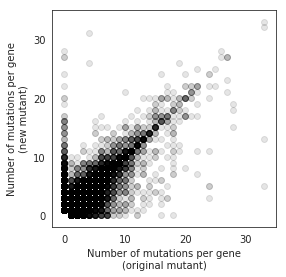

In [22]:
plt.figure(figsize=(4, 4))

for i, strain in enumerate(['S288C', 'Y55',
                            'YPS', 'UWOP']):
    for gene in {x.split('_')[1] for x in a.columns
                 if x.split('_')[0] == strain}:
        v = a[['%s_%s_original' % (strain, gene),
               '%s_%s_new' % (strain, gene),]].dropna()
        v['delta'] = abs(v[v.columns[0]] - v[v.columns[1]])
        plt.plot(v[v.columns[0]],
                 v[v.columns[1]],
                 'ko',
                 alpha=0.1,
                 rasterized=True)
    
plt.xlim(-2, 35)
plt.ylim(-2, 35)

plt.xlabel('Number of mutations per gene\n(original mutant)')
plt.ylabel('Number of mutations per gene\n(new mutant)')

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(4))

plt.savefig('ko_sequencing_snps.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('ko_sequencing_snps.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [23]:
for i, strain in enumerate(['S288C', 'Y55',
                            'YPS', 'UWOP']):
    for gene in {x.split('_')[1] for x in a.columns
                 if x.split('_')[0] == strain}:
        v = a[['%s_%s_original' % (strain, gene),
               '%s_%s_new' % (strain, gene),]].dropna()
        v['delta'] = abs(v[v.columns[0]] - v[v.columns[1]])
        v = v[(v['%s_%s_original' % (strain, gene)] == 0) & (v['delta'] > 5)]
        if v.shape[0] > 0:
            print(strain, gene, ' // ',  ', '.join(sorted(v.index)))

Y55 AVL9  //  AIM3, AMD2, APC5, ATG9, BNI4, BNI5, BPT1, BTN2, CBF2, CCC2, CCZ1, CHS1, CMR1, CRF1, DSE3, DUR1,2, EBS1, ECM3, EXO5, GTB1, HER1, HUA2, INP52, IRA1, ISW2, KEX2, KIN4, LYS4, MEP2, MSB1, MSH5, NAM9, NUP1, POL5, POP1, PSD2, RAD9, RIM20, RKM2, RNH202, SIR4, SND1, SNU56, SPA2, TAF2, TDA7, THO2, TPO4, TRM3, TRS65, TYR1, UBP10, ULS1, UPC2, YEF1, ZIP1
YPS ERG2  //  BNI1, BPH1, CAF120, FRE7, HAL9, HMI1, LYP1, PGD1, SED4, SNT1, SNU66, SRB8, SSK22, TAF2, TOF1
YPS SLM1  //  BNI4, CAF120, GAL4, GUP2, GYP5, HOS4, KEX2, LYP1, MON1, NUP159, POP1, PRM5, QDR1, RGC1, RTT10, SNT1, SNT2, SPC105, SPO22, SYT1, VPS75, XBP1, YBP2
YPS AVL9  //  APE2, ARO80, ATP22, CAD1, CAF120, CCH1, EAF1, FLO8, FRE3, HER1, HKR1, KEX2, KRE2, LYP1, MAL31, NUP157, POP1, RAD2, SDL1, SHE9, SNT1, TAF2, TOS2, VPS72, VPS75, XRS2
UWOP ERG2  //  AIM3, ARP2, BOI2, BPH1, BSC1, BUD3, CCZ1, ECM33, EHD3, EXO5, FLO8, GIP1, GPR1, IRA1, IST2, KCS1, KRS1, MED2, MMS4, MRX9, NPP1, NUP157, OSH2, PFF1, PMD1, POL5, PRM7, RAD61, REG1, RIF1

In [24]:
for i, strain in enumerate(['S288C', 'Y55',
                            'YPS', 'UWOP']):
    for gene in {x.split('_')[1] for x in a.columns
                 if x.split('_')[0] == strain}:
        v = a[['%s_%s_original' % (strain, gene),
               '%s_%s_new' % (strain, gene),]].dropna()
        v['delta'] = abs(v[v.columns[0]] - v[v.columns[1]])
        v = v[(v['%s_%s_new' % (strain, gene)] == 0) & (v['delta'] > 5)]
        if v.shape[0] > 0:
            print(strain, gene, ' // ',  ', '.join(sorted(v.index)))

YPS SLM1  //  MDM20, MET18, MLP1, MLP2, MYO1, NMD2, NUP188, SPP41, ZIP1
YPS AVL9  //  CDC39, ENV11, HDA3, HPC2, JEM1, LTE1, MDM20, MET18, MLP1, MLP2, MRX9, MYO1, NFT1, NMD2, NUP188, PDS5, SAS3, SEG2, SIR4, SNU66, SPO71, STE5, USO1, ZIP1
